In [7]:
from __future__ import print_function, division

import os
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.io
from datetime import datetime
import socket
import timeit

import torch
import torchvision as tv
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.utils.model_zoo as model_zoo

In [27]:
inputs = pd.read_csv('dataset/train_x.csv').drop('Unnamed: 0',axis = 1).to_numpy()

In [31]:
inputs[:,0].shape

(116,)

In [32]:
class ROIDataset(Dataset):

    def __init__(self, mode, root_dir, transform = None):
        self.root_dir = root_dir
        self.mode = mode
        inputs = pd.read_csv(root_dir+mode+'_x.csv').drop('Unnamed: 0',axis = 1)
        targets = pd.read_csv(root_dir+mode+'_y.csv').drop('Unnamed: 0',axis = 1)
        self.inputs = inputs.to_numpy()
        self.targets = targets.to_numpy()
        self.transform = transform
 
    def __len__(self):
        """""""""
        Get the number of time points of one subject
        """""""""
        return len(self.targets[0,:])
    
    
    def __getitem__(self, idx):
        """
        Get the both data and target at idx time point     
        """
        #print(self.fMRI_data.shape)
        inputs = self.inputs[:,idx]
        targets = self.targets[:,idx]
        return inputs, targets

In [37]:
trainset = ROIDataset('train', 'dataset/', transform=None)
dataloader = DataLoader(trainset, batch_size = 4,  shuffle=False)

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [77]:
import torch.nn as nn 
import torch.nn.functional as F

# This is our neural networks class that inherits from nn.Module 
class fullNet(nn.Module):

# Here we define our network structure 
    def __init__(self):

        super(fullNet, self).__init__() 
        self.fc1 = nn.Linear(116, 30) 
        self.bn1 = nn.BatchNorm1d(num_features=30)

        self.fc2 = nn.Linear(30, 2) 
        self.bn2 = nn.BatchNorm1d(2)
        self.dropout = nn.Dropout(0.5) 
        """"         
        self.fc3 = nn.Linear(29, 2)
        self.bn3 = nn.BatchNorm1d(2)
        self.dropout = nn.Dropout(0.5) 
        """""
# Here we define one forward pass through the network 
    def forward(self, x):
        y = F.relu(self.bn1(self.fc1(x)))
        y = F.relu(self.bn2(self.fc2(y)))
        #y = F.relu(self.bn3(self.fc3(y)))
        y = self.dropout(y)
        return y

# Determine the number of features in a batch of tensors 
    def num_flat_features(self, x ):

        size = x.size()[1:] 
        return np.prod(size)

net = fullNet()
net = net.double()
print(net)

fullNet(
  (fc1): Linear(in_features=116, out_features=30, bias=True)
  (bn1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=30, out_features=2, bias=True)
  (bn2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [55]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1,
                               kernel_size=5,
                               stride=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(20)
        self.dense1 = nn.Linear(in_features=320, out_features=50)
        self.dense1_bn = nn.BatchNorm1d(50)
        self.dense2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)), 2))
        x = x.view(-1, 320) #reshape
        x = F.relu(self.dense1_bn(self.dense1(x)))
        x = F.relu(self.dense2(x))
        return F.log_softmax(x)

In [52]:
net = Net()
net = net.double()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=320, out_features=50, bias=True)
  (dense1_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=50, out_features=10, bias=True)
)


In [69]:
## training
loss_func = nn.MSELoss()
opt = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

In [78]:
avg_losses = []
epochs = 10
print_freq = 100

for epoch in range(epochs): # Loop over the dataset multiple times.
    running_loss = 0.0 # Initialize running loss.
    for i, data in enumerate(dataloader, 0):
    # Get the inputs.
        inputs, labels = data
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()
        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        # Backward step.
        loss.backward()
        # Optimization step (update the parameters).
        opt.step()
        # Print statistics.
        running_loss += loss.item()
        # Print every several mini-batches.
        if i % print_freq == print_freq - 1: 
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.
            format(
            epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 0.945
[epoch: 0, i:   199] avg mini-batch loss: 1.041
[epoch: 0, i:   299] avg mini-batch loss: 0.930
[epoch: 0, i:   399] avg mini-batch loss: 0.927
[epoch: 0, i:   499] avg mini-batch loss: 0.947
[epoch: 0, i:   599] avg mini-batch loss: 0.996
[epoch: 0, i:   699] avg mini-batch loss: 1.004
[epoch: 0, i:   799] avg mini-batch loss: 0.951
[epoch: 0, i:   899] avg mini-batch loss: 0.935
[epoch: 0, i:   999] avg mini-batch loss: 0.975
[epoch: 0, i:  1099] avg mini-batch loss: 0.943
[epoch: 0, i:  1199] avg mini-batch loss: 1.040
[epoch: 0, i:  1299] avg mini-batch loss: 0.983
[epoch: 0, i:  1399] avg mini-batch loss: 0.956
[epoch: 0, i:  1499] avg mini-batch loss: 1.007
[epoch: 0, i:  1599] avg mini-batch loss: 1.003
[epoch: 0, i:  1699] avg mini-batch loss: 1.113
[epoch: 0, i:  1799] avg mini-batch loss: 0.990
[epoch: 0, i:  1899] avg mini-batch loss: 0.991
[epoch: 0, i:  1999] avg mini-batch loss: 1.014
[epoch: 0, i:  2099] avg mini-batch loss

[epoch: 6, i:  2199] avg mini-batch loss: 0.998
[epoch: 6, i:  2299] avg mini-batch loss: 0.997
[epoch: 6, i:  2399] avg mini-batch loss: 1.009
[epoch: 6, i:  2499] avg mini-batch loss: 0.951
[epoch: 7, i:    99] avg mini-batch loss: 0.981
[epoch: 7, i:   199] avg mini-batch loss: 1.055
[epoch: 7, i:   299] avg mini-batch loss: 1.019
[epoch: 7, i:   399] avg mini-batch loss: 1.079
[epoch: 7, i:   499] avg mini-batch loss: 0.944
[epoch: 7, i:   599] avg mini-batch loss: 1.082
[epoch: 7, i:   699] avg mini-batch loss: 0.982
[epoch: 7, i:   799] avg mini-batch loss: 0.960
[epoch: 7, i:   899] avg mini-batch loss: 0.986
[epoch: 7, i:   999] avg mini-batch loss: 0.972
[epoch: 7, i:  1099] avg mini-batch loss: 0.953
[epoch: 7, i:  1199] avg mini-batch loss: 1.022
[epoch: 7, i:  1299] avg mini-batch loss: 1.097
[epoch: 7, i:  1399] avg mini-batch loss: 0.976
[epoch: 7, i:  1499] avg mini-batch loss: 0.950
[epoch: 7, i:  1599] avg mini-batch loss: 0.960
[epoch: 7, i:  1699] avg mini-batch loss

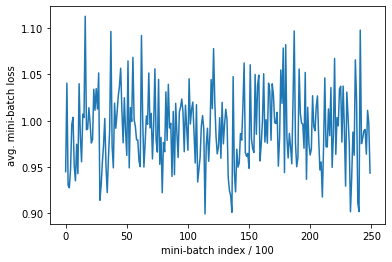

In [79]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()